In [26]:
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random as random

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDClassifier

from calibration_util import *
%matplotlib inline

In [5]:
def scale(data, col):
    data[col] = (data[col]-data[col].min()) / (data[col].max() - data[col].min())
    
def normalize(df):
    return(df - df.mean()) / df.std()

def split_data_norm(data):
    test = data.sample(frac=0.5, random_state=42)
    test=normalize(test)
    train_all = data.drop(test.index)
    train_all=normalize(train_all)
    tune = train_all.sample(frac=0.2, random_state=42)
    train = train_all.drop(tune.index)
    print("test ", test.shape)
    print("train_all ",train_all.shape)
    print("tune ",tune.shape)
    print("train ",train.shape)
    return np.nan_to_num(test), np.nan_to_num(train_all), np.nan_to_num(tune), np.nan_to_num(train)

def split_data(data):
    test = data.sample(frac=0.5, random_state=42)
    train_all = data.drop(test.index)
    #1,000
    tune = train_all.sample(frac=0.2, random_state=42)
    train = train_all.drop(tune.index)
    print("test ", test.shape)
    print("train_all ",train_all.shape)
    print("tune ",tune.shape)
    print("train ",train.shape)
    return np.nan_to_num(test), np.nan_to_num(train_all), np.nan_to_num(tune), np.nan_to_num(train)

In [6]:
#read in data sets
adult=pd.read_csv("C:/Users/Caitlin/Documents/git/fair_ranking/data/adult.data", header=None)
bank=pd.read_csv("C:/Users/Caitlin/Documents/git/fair_ranking/data/bank-full.csv", sep=";")
default=pd.read_csv("C:/Users/Caitlin/Documents/git/fair_ranking/data/default.csv")
churn=pd.read_csv("C:/Users/Caitlin/Documents/git/fair_ranking/data/ibm_churn.csv")
evaluation=pd.read_csv("C:/Users/Caitlin/Documents/git/fair_ranking/data/ibm_eval.csv")


In [37]:
# bank_g
bank['marital'][bank['marital']=='divorced'] = 'single'
print("# single", (bank['marital']=='single').sum())
print("# married", (bank['marital']=='married').sum())

# single 17997
# married 27214


C:\Users\Caitlin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
adult_g = pd.get_dummies(adult[9],drop_first=True)
adult_y = adult[10]
adult_X = pd.get_dummies(adult.drop([9,10], axis=1))
# adult_X.head()
bank_g = pd.get_dummies(bank['marital'],drop_first=True)
bank_y = bank['balance']
bank_X = pd.get_dummies(bank.drop(['marital','balance'], axis=1))
# bank_X.head()
default_g = pd.get_dummies(default['SEX'],drop_first=True)
default_y = default['LIMIT_BAL']
default_X = pd.get_dummies(default.drop(['SEX','LIMIT_BAL','ID'], axis=1))
# default_X.head()
churn_g = pd.get_dummies(churn['gender'],drop_first=True)
churn_y = churn['MonthlyCharges']
churn_X = pd.get_dummies(churn.drop(['customerID','MonthlyCharges','gender','TotalCharges'],axis=1))
# churn_X.head()
# evaluation.columns.values
evaluation_g = pd.get_dummies(evaluation['Gender'],drop_first=True)
evaluation_y = evaluation['MonthlyIncome']
evaluation_X = pd.get_dummies(evaluation.drop(['MonthlyIncome','Gender'], axis=1))
# evaluation_X.head()

In [47]:
def run(data_g,data_y,data_X):
    print("groups")
    test_g, train_all_g, tune_g, train_g = split_data(data_g)
    print("y")
    test_y, train_all_y, tune_y, train_y = split_data_norm(data_y)
    print("X")
    test_X, train_all_X, tune_X, train_X = split_data_norm(data_X)
    
    lr = LinearRegression()
    #linear regression
    lr.fit(train_all_X, train_all_y)
    lr_y_pred = lr.predict(test_X)
    lr_err = mse(lr_y_pred, test_y)
    print("linear regression mse: ", lr_err)
    
    df_lr=pd.DataFrame()
    df_lr['y']=test_y
    df_lr['y_pred']=lr_y_pred
    df_lr['g']=test_g
    
    
    #LASSO
    errs=[]
    depths = [0.1, 0.3,0.5,0.7,1]
    for depth in depths:
        kf = KFold(n_splits=5, shuffle=True, random_state=99)
        mses =[]
        for train_index, test_index in kf.split(tune_X):
            la = Lasso(alpha=depth, fit_intercept=True, max_iter=1000, tol=0.0001)
            la.fit(tune_X[train_index], tune_y[train_index])
            la_y_pred = la.predict(tune_X[test_index])
            mses.append(mse(la_y_pred, tune_y[test_index]))
        errs.append(np.sum(mses))
    best = np.argmin(errs)
    print("best alpha: ", depths[best])
    
    la = Lasso(alpha=depths[best], fit_intercept=True, max_iter=1000, tol=0.0001)
    la.fit(train_X[train_index], train_y[train_index])

    la_y_pred = la.predict(test_X)
    la_err = mse(la_y_pred, test_y)
    print("lasso mse: ", la_err)
    
    df_la=pd.DataFrame()
    df_la['y']=test_y
    df_la['y_pred']=la_y_pred
    df_la['g']=test_g
    
    #DECISON TREE
    errs=[]
    depths = [1,2,3,5,7,9]
    for depth in depths:
        kf = KFold(n_splits=5, shuffle=True, random_state=99)
        mses =[]
    
        for train_index, test_index in kf.split(tune_X):
            dt = DecisionTreeRegressor(max_depth=depth)
            dt.fit(tune_X[train_index], tune_y[train_index])
            y_pred = dt.predict(tune_X[test_index])
            y = tune_y[test_index]
            mses.append(mse(y_pred, tune_y[test_index]))
        
        errs.append(np.sum(mses))
    best = np.argmin(errs)
    print("best depth of tree: ", depths[best])
    
    dt = DecisionTreeRegressor(max_depth=depths[best])
    dt.fit(train_X[train_index], train_y[train_index])

    dt_y_pred = dt.predict(test_X)
    dt_err = mse(dt_y_pred, test_y)
    print("decision tree mse: ", dt_err)
    
    df_dt=pd.DataFrame()
    df_dt['y']=test_y
    df_dt['y_pred']=dt_y_pred
    df_dt['g']=test_g
    
    
    #RANDOM FOREST
    errs=[]
    depths = [1,2,3,5,7,9]
    for depth in depths:
        mses =[]
        for train_index, test_index in kf.split(tune_X):
            rf = RandomForestRegressor(max_depth=depth)
            rf.fit(tune_X[train_index], tune_y[train_index])
            y_pred = rf.predict(tune_X[test_index])
            y = tune_y[test_index]
            mses.append(mse(y_pred, tune_y[test_index]))
        
        errs.append(np.sum(mses)/len(mses))
    best = np.argmin(errs)
    print("best depth of tree: ", depths[best])
    
    rf = RandomForestRegressor(max_depth=depths[best])
    rf.fit(train_X[train_index], train_y[train_index])

    rf_y_pred = rf.predict(test_X)
    rf_err = mse(rf_y_pred, test_y)
    print("random forest mse: ", rf_err)

    df_rf=pd.DataFrame()
    df_rf['y']=test_y
    df_rf['y_pred']=rf_y_pred
    df_rf['g']=test_g
    
    #LINEAR SVM
    errs=[]
    depths = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    for depth in depths:
        mses =[]
        for train_index, test_index in kf.split(tune_X):
            svr = LinearSVR(epsilon=0.0, tol=0.0001, loss= 'squared_epsilon_insensitive', C=depth, dual=False, max_iter=1000)
            svr.fit(tune_X[train_index], tune_y[train_index])
            y_pred = svr.predict(tune_X[test_index])
            y = tune_y[test_index]
            mses.append(mse(y_pred, tune_y[test_index]))
            
        errs.append(np.sum(mses)/len(mses))
    best = np.argmin(errs)
    print("Best C value: ", depths[best])
    
    svr = LinearSVR(epsilon=0.0, tol=0.0001, loss='squared_epsilon_insensitive', C=depths[best], dual=False, max_iter=1000) 
    svr.fit(train_X[train_index], train_y[train_index])

    svr_y_pred = svr.predict(test_X)
    svr_err = mse(svr_y_pred, test_y)
    print("linear svm: ", svr_err)
    
    df_svr=pd.DataFrame()
    df_svr['y']=test_y
    df_svr['y_pred']=svr_y_pred
    df_svr['g']=test_g
    
    return df_la, df_dt, df_rf, df_svr

In [50]:
#use 25% of the data for testing, and rest for calibration
def train_test_short(df, folds, nbins):
    cv_errors =pd.DataFrame()
    train = df.sample(frac=0.25, random_state=80)
    test = df.drop(train.index)

    y_pred_baseline = test['y_pred']

    y_pred_cal = get_calibrated_predictions(train, test)
    
    y_pred0, y_pred1 = get_groupwise_calibrated_predictions(train, test)
    y_pred_all = np.append(y_pred0, y_pred1)

    y_test0 = test[test['g']==0.]['y']
    y_test1 = test[test['g']==1.]['y']
    y_test_all = np.append(y_test0, y_test1)

    g_test0 = test[test['g']==0.]['g']
    g_test1 = test[test['g']==1.]['g']
    g_test_all = np.append(g_test0, g_test1)

    y_test = np.array(test['y'])
    g_test = np.array(test['g'])

    b_errors = get_bin_errors(y_pred_baseline, y_test, g_test, nbins).mean()
    cv_errors["baseline"] = b_errors
    c_errors = get_bin_errors(y_pred_cal, y_test, g_test, nbins).mean()
    cv_errors["calibrate"] = c_errors
    cg_errors = get_bin_errors(y_pred_all, y_test_all, g_test_all, nbins).mean()
    cv_errors["cal_groups"] = cg_errors
    cv_errors.index = ['Mean Squared Error', 'Absolute Error', 'Overestimation','Underestimation', 'Spearman Rho', 'Kendall Tau', 'KL divergence']

    return cv_errors

In [103]:
def stabalize_cv(df, folds, nbins):
    df1 = cv_short(df, folds, nbins)
    df2 = cv_short(df, folds, nbins)
    df3 = cv_short(df, folds, nbins)
    return (df1+df2+df3)/3

#use 25% of the data for testing, and rest for calibration
def cv_short(df, folds, nbins):
    cv_errors =pd.DataFrame()
    cv_errors["baseline"] = np.zeros(7)
    cv_errors["calibrate"] = np.zeros(7)
    cv_errors["cal_groups"] = np.zeros(7)
    kf = KFold(n_splits=folds, shuffle=True)
    
    for train_index, test_index in kf.split(df):
        train = df.iloc[train_index]
        test = df.drop(train.index)

        y_pred_baseline = test['y_pred']

        y_pred_cal = get_calibrated_predictions(train, test)

        y_pred0, y_pred1 = get_groupwise_calibrated_predictions(train, test)
        y_pred_all = np.append(y_pred0, y_pred1)

        y_test0 = test[test['g']==0.]['y']
        y_test1 = test[test['g']==1.]['y']
        y_test_all = np.append(y_test0, y_test1)

        g_test0 = test[test['g']==0.]['g']
        g_test1 = test[test['g']==1.]['g']
        g_test_all = np.append(g_test0, g_test1)

        y_test = np.array(test['y'])
        g_test = np.array(test['g'])

        b_errors = np.array(get_bin_errors(y_pred_baseline, y_test, g_test, nbins).mean())
        cv_errors["baseline"] = cv_errors["baseline"] + b_errors
        c_errors = np.array(get_bin_errors(y_pred_cal, y_test, g_test, nbins).mean())
        cv_errors["calibrate"] = cv_errors["calibrate"] + c_errors
        cg_errors = np.array(get_bin_errors(y_pred_all, y_test_all, g_test_all, nbins).mean())
        cv_errors["cal_groups"] = cv_errors["cal_groups"] +cg_errors
        cv_errors.index = ['Mean Squared Error', 'Absolute Error', 'Overestimation','Underestimation', 'Spearman Rho', 'Kendall Tau', 'KL divergence']

    cv_errors=cv_errors / folds
    cv_errors.index = ['Mean Squared Error', 'Absolute Error', 'Overestimation','Underestimation', 'Spearman Rho', 'Kendall Tau', 'KL divergence']

    return cv_errors

In [62]:
# df_lr, df_dt, df_rf, df_svr = run(adult_g,adult_y,adult_X)
# df_lr, df_dt, df_rf, df_svr = run(bank_g, bank_y, bank_X)
# df_lr, df_dt, df_rf, df_svr = run(default_g, default_y, default_X)
df_lr, df_dt, df_rf, df_svr = run(churn_g, churn_y, churn_X)
# df_lr, df_dt, df_rf, df_svr = run(evaluation_g, evaluation_y, evaluation_X)

groups
test  (3522, 1)
train_all  (3521, 1)
tune  (704, 1)
train  (2817, 1)
y
test  (3522,)
train_all  (3521,)
tune  (704,)
train  (2817,)
X
test  (3522, 43)
train_all  (3521, 43)
tune  (704, 43)
train  (2817, 43)
linear regression mse:  7.17944731048e+19
best alpha:  0.1
lasso mse:  0.0492928997617
best depth of tree:  9
decision tree mse:  0.019711036509
best depth of tree:  9
random forest mse:  0.011061710023
Best C value:  10
linear svm:  0.0014880828508


In [63]:
print("lasso")
print(train_test_short(df_lr, 10,10))
print("\ndecision tree")
print(train_test_short(df_dt,10,10))
print("\nranfom forest")
print(train_test_short(df_rf,10,10))
print("\nsvr")
print(train_test_short(df_svr,10,10))

lasso


C:\Users\Caitlin\Documents\git\fair_ranking\calibration_util.py:75: RuntimeWarning: invalid value encountered in double_scalars
  return np.cov(a,b)[0][1] / (np.std(a)*np.std(b))


                    baseline  calibrate  cal_groups
Mean Squared Error  0.006775   0.001477    0.002327
Absolute Error      2.076340   0.830970    1.342027
Overestimation      0.881038   0.713285    1.997095
Underestimation     1.808866   0.591961    1.431506
Spearman Rho        0.099757   0.058686    0.056329
Kendall Tau         0.096634   0.066174    0.068596
KL divergence       0.003074   0.002454    0.000776

decision tree
                    baseline  calibrate  cal_groups
Mean Squared Error  0.002745   0.003122    0.003275
Absolute Error      0.717236   0.786677    1.407289
Overestimation      0.909940   0.847985    2.854202
Underestimation     0.964338   0.728957    1.804608
Spearman Rho        0.050424   0.053759    0.101746
Kendall Tau         0.064129   0.065495    0.081625
KL divergence            inf        inf         inf

ranfom forest
                    baseline  calibrate  cal_groups
Mean Squared Error  0.001633   0.002229    0.002233
Absolute Error      1.035780   1.2

In [73]:
lr_err = train_test_short(df_lr, 10,10)
dt_err = train_test_short(df_dt,10,10)
rf_err = train_test_short(df_rf,10,10)
svr_err = train_test_short(df_svr,10,10)

C:\Users\Caitlin\Documents\git\fair_ranking\calibration_util.py:75: RuntimeWarning: invalid value encountered in double_scalars
  return np.cov(a,b)[0][1] / (np.std(a)*np.std(b))


In [79]:
a_lr, a_dt, a_rf, a_svr = run(adult_g,adult_y,adult_X)
b_lr, b_dt, b_rf, b_svr = run(bank_g, bank_y, bank_X)
d_lr, d_dt, d_rf, d_svr = run(default_g, default_y, default_X)
c_lr, c_dt, c_rf, c_svr = run(churn_g, churn_y, churn_X)
e_lr, e_dt, e_rf, e_svr = run(evaluation_g, evaluation_y, evaluation_X)

groups
test  (16280, 1)
train_all  (16281, 1)
tune  (3256, 1)
train  (13025, 1)
y
test  (16280,)
train_all  (16281,)
tune  (3256,)
train  (13025,)
X
test  (16280, 107)
train_all  (16281, 107)
tune  (3256, 107)
train  (13025, 107)
linear regression mse:  6.48069835025e+22
best alpha:  0.1
lasso mse:  0.9494928793
best depth of tree:  1
decision tree mse:  0.97630940286
best depth of tree:  2
random forest mse:  0.957555570249
Best C value:  0.0001
linear svm:  0.944557919134
groups
test  (22606, 1)
train_all  (22605, 1)
tune  (4521, 1)
train  (18084, 1)
y
test  (22606,)
train_all  (22605,)
tune  (4521,)
train  (18084,)
X
test  (22606, 49)
train_all  (22605, 49)
tune  (4521, 49)
train  (18084, 49)
linear regression mse:  5.98818158904e+20
best alpha:  0.1
lasso mse:  1.00212331609
best depth of tree:  3
decision tree mse:  1.02349120004
best depth of tree:  2
random forest mse:  0.99500253631
Best C value:  0.001
linear svm:  0.972615780332
groups
test  (15000, 1)
train_all  (15000, 1)
t

In [105]:
def plot_metric(err):
    lasso_errs = pd.DataFrame()
    a = stabalize_cv(a_lr, 10,10).transpose()[err]
    b = stabalize_cv(b_lr, 10,10).transpose()[err]
    c = stabalize_cv(c_lr, 10,10).transpose()[err]
    d = stabalize_cv(d_lr, 10,10).transpose()[err]
    e = stabalize_cv(e_lr, 10,10).transpose()[err]
    lasso_errs["a"] = a 
    lasso_errs["b"] = b
    lasso_errs["c"] = c
    lasso_errs["d"] = d
    lasso_errs["e"] = e
    lasso_errs.plot(title="Lasso")
    lasso_errs = pd.DataFrame()
    lasso_errs["a"] = stabalize_cv(a_dt, 10,10).transpose()[err]
    lasso_errs["b"] = stabalize_cv(b_dt, 10,10).transpose()[err]
    lasso_errs["c"] = stabalize_cv(c_dt, 10,10).transpose()[err]
    lasso_errs["d"] = stabalize_cv(d_dt, 10,10).transpose()[err]
    lasso_errs["e"] = stabalize_cv(e_dt, 10,10).transpose()[err]
    lasso_errs.plot(title="Decision Tree")
    lasso_errs = pd.DataFrame()
    lasso_errs["a"] = stabalize_cv(a_rf, 10,10).transpose()[err]
    lasso_errs["b"] = stabalize_cv(b_rf, 10,10).transpose()[err]
    lasso_errs["c"] = stabalize_cv(c_rf, 10,10).transpose()[err]
    lasso_errs["d"] = stabalize_cv(d_rf, 10,10).transpose()[err]
    lasso_errs["e"] = stabalize_cv(e_rf, 10,10).transpose()[err]
    lasso_errs.plot(title = "Random Forest")
    lasso_errs = pd.DataFrame()
    lasso_errs["a"] = stabalize_cv(a_svr, 10,10).transpose()[err]
    lasso_errs["b"] = stabalize_cv(b_svr, 10,10).transpose()[err]
    lasso_errs["c"] = stabalize_cv(c_svr, 10,10).transpose()[err]
    lasso_errs["d"] = stabalize_cv(d_svr, 10,10).transpose()[err]
    lasso_errs["e"] = stabalize_cv(e_svr, 10,10).transpose()[err]
    lasso_errs.plot(title="SVR")

In [ ]:
# plot_metric('Mean Squared Error')
print('Mean Squared Error')
plot_metric('Mean Squared Error')
print("Overestimated")
plot_metric('Overestimation')
print("Underestimated")
plot_metric('Underestimation')
print("Kendall Tau")
plot_metric('Kendall Tau')
# 'Spearman Rho', 'Kendall Tau', 'KL divergence'

Overestimated


C:\Users\Caitlin\Documents\git\fair_ranking\calibration_util.py:75: RuntimeWarning: invalid value encountered in double_scalars
  return np.cov(a,b)[0][1] / (np.std(a)*np.std(b))
C:\Users\Caitlin\Anaconda3\lib\site-packages\scipy\stats\stats.py:3577: RuntimeWarning: invalid value encountered in double_scalars
  size * (size - 1) * (size - 2))


Underestimated


C:\Users\Caitlin\Documents\git\fair_ranking\calibration_util.py:75: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a,b)[0][1] / (np.std(a)*np.std(b))
C:\Users\Caitlin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
C:\Users\Caitlin\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3093: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


Kendall Tau


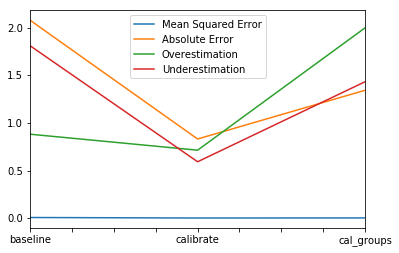

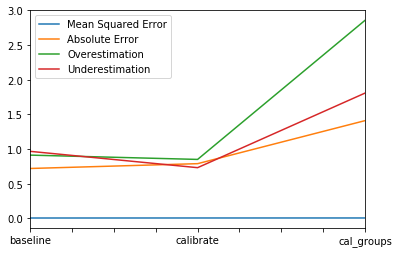

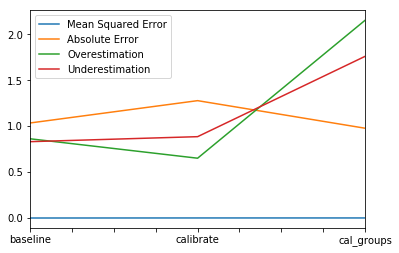

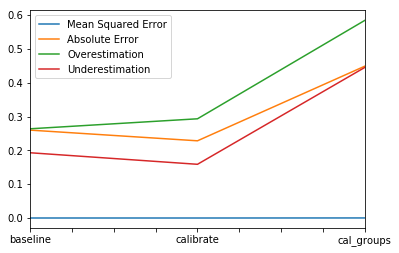

In [75]:
lr_err.transpose()[['Mean Squared Error', 'Absolute Error', 'Overestimation','Underestimation']].plot()
dt_err.transpose()[['Mean Squared Error', 'Absolute Error', 'Overestimation','Underestimation']].plot()
rf_err.transpose()[['Mean Squared Error', 'Absolute Error', 'Overestimation','Underestimation']].plot()
svr_err.transpose()[['Mean Squared Error', 'Absolute Error', 'Overestimation','Underestimation']].plot()

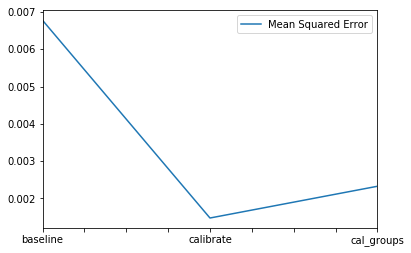

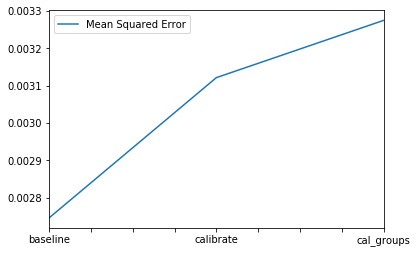

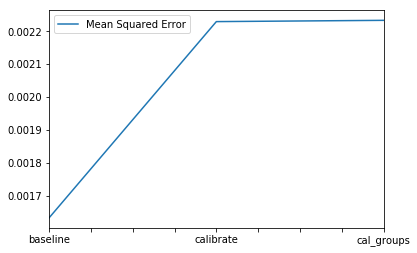

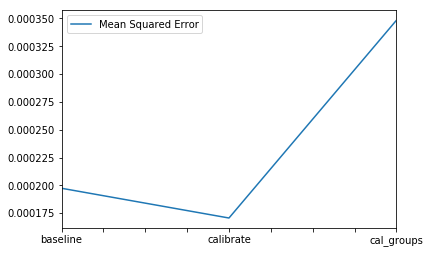

In [78]:
lr_err.transpose()[['Mean Squared Error']].plot()
dt_err.transpose()[['Mean Squared Error']].plot()
rf_err.transpose()[['Mean Squared Error']].plot()
svr_err.transpose()[['Mean Squared Error']].plot()

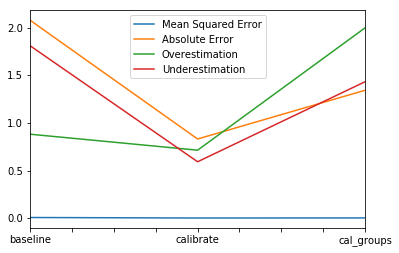

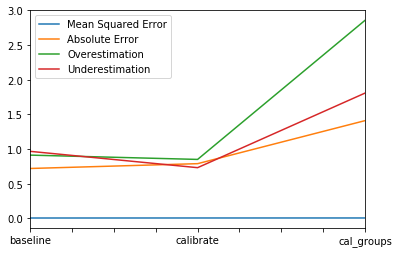

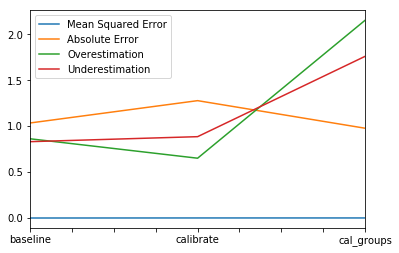

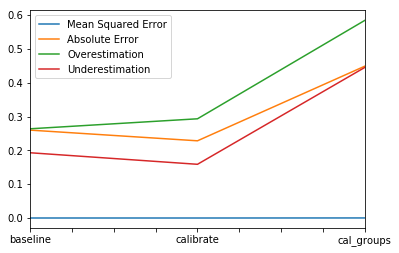

In [75]:
lr_err.transpose()[['Mean Squared Error', 'Absolute Error', 'Overestimation','Underestimation']].plot()
dt_err.transpose()[['Mean Squared Error', 'Absolute Error', 'Overestimation','Underestimation']].plot()
rf_err.transpose()[['Mean Squared Error', 'Absolute Error', 'Overestimation','Underestimation']].plot()
svr_err.transpose()[['Mean Squared Error', 'Absolute Error', 'Overestimation','Underestimation']].plot()

In [49]:
train_test_short(df_rf,10,10,10)

C:\Users\Caitlin\Documents\git\fair_ranking\calibration_util.py:70: RuntimeWarning: invalid value encountered in double_scalars
  return np.cov(a,b)[0][1] / (np.std(a)*np.std(b))


,baseline,calibrate,cal_groups
Mean Squared Error,0.880738,0.910989,0.890947
Absolute Error,180.509393,153.104360,166.836397
Overestimation,76.903363,40.792441,59.596264
Underestimation,103.606030,112.311919,107.240133
Spearman Rho,0.126254,0.078153,0.041007
Kendall Tau,0.042183,0.038103,0.075532
KL divergence,NaN,NaN,NaN


In [50]:
train_test_short(df_svr,10,10,10)

C:\Users\Caitlin\Documents\git\fair_ranking\calibration_util.py:70: RuntimeWarning: invalid value encountered in double_scalars
  return np.cov(a,b)[0][1] / (np.std(a)*np.std(b))


,baseline,calibrate,cal_groups
Mean Squared Error,0.890299,0.842717,0.861921
Absolute Error,187.912627,196.520534,201.862261
Overestimation,82.831457,100.713429,105.668526
Underestimation,105.081169,95.807105,96.193735
Spearman Rho,0.061474,0.074781,0.085645
Kendall Tau,0.040377,0.046455,0.044970
KL divergence,NaN,NaN,NaN


In [113]:
stabalize_cv(df_svr,5,10)

C:\Users\Caitlin\Documents\git\fair_ranking\calibration_util.py:70: RuntimeWarning: invalid value encountered in double_scalars
  return np.cov(a,b)[0][1] / (np.std(a)*np.std(b))


,baseline,calibrate,cal_groups
Mean Squared Error,0.830066,0.822597,0.885001
Absolute Error,231.323487,249.628636,256.105415
Overestimation,103.062242,134.402756,140.573075
Underestimation,128.261246,115.225880,115.535389
Spearman Rho,0.068598,0.083636,0.059770
Kendall Tau,0.048787,0.060349,0.049993
KL divergence,NaN,NaN,NaN
